<a href="https://colab.research.google.com/github/AllMight2099/ml4sci-qcnn-eval/blob/master/Task_IV_Classical_GNN_Part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

!pip install stellargraph --quiet
!pip install energyflow --quiet
!pip install dgcnn --quiet

# Load Data

---



In [7]:
import energyflow
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt 

In [8]:
x,y = energyflow.qg_jets.load(num_data=100000, pad=True, ncol=4, generator='pythia',
                         with_bc=True, cache_dir='~/.energyflow')
print(x.shape)
X = []
for i in x:
  X.append(i[0])
X = np.array(X)
X.shape

(100000, 134, 4)


(100000, 4)

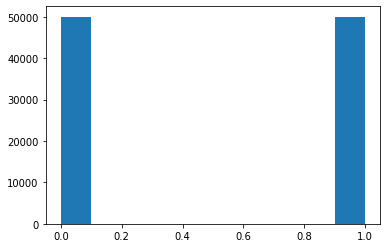

In [9]:
plt.hist(y)
plt.show()

# Encoding each Data Sample into a Graph


---


### Using **Stellargraph** to create a list of 100000 graphs

In [10]:
from stellargraph import StellarGraph
from stellargraph import IndexedArray
import pandas as pd
squared_numeric_edges = pd.DataFrame(
    {"source": [0, 1, 2, 3, 0], "target": [1, 2, 3, 0, 2]}
)
print(squared_numeric_edges)
X_train = []

for features in X:
  feature_array=[]
  for feature in features:
    feature_array.append(feature)
  indexed_array = IndexedArray(np.array([feature_array]).T, index=[0,1,2,3])
  G = StellarGraph(indexed_array, squared_numeric_edges,node_type_default="corner", edge_type_default="line")
  X_train.append(G)

   source  target
0       0       1
1       1       2
2       2       3
3       3       0
4       0       2


In [11]:
graphs=X_train
graph_labels= pd.DataFrame(y, columns = ['Classification'])
graphs[0].info()

'StellarGraph: Undirected multigraph\n Nodes: 4, Edges: 5\n\n Node types:\n  corner: [4]\n    Features: float64 vector, length 1\n    Edge types: corner-line->corner\n\n Edge types:\n    corner-line->corner: [5]\n        Weights: all 1 (default)\n        Features: none'

# **Supervised graph classification with Deep Graph CNN** 


---


In supervised graph classification, we are given a collection of graphs each 
with an attached categorical label. 
* My goal is to train a model that uses the graph structure of the data and the given properties for each jet, to predict the correct label for a previously unseen graph; a previously unseen graph is one that was not used for training and validating the model.


I'm going ahead with the **Deep Graph Convolutional Neural Network** for this task.

* The DGCNN architecture was proposed in [[1]](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146) using the graph convolutional layers from [[2]](https://arxiv.org/abs/1609.02907) but with a **modified propagation rule **(see [[1]](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146) for details). 

* DGCNN introduces a new **`SortPooling layer`** to generate a representation (also know as embedding) for each given graph using as input the representations learned for each node via a stack of **graph convolutional layers**. 
* The **output** of the `SortPooling layer` is then used as input to **1D convolutional, max pooling, and dense layers** that learn graph-level features suitable for predicting graph labels.



In [ ]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

In [ ]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)
graph_labels.value_counts().to_frame()
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

# Prepare **Graph Generato**r and create the **Keras graph classification** model


To feed data to the `tf.Keras` model that we will create later, we need a data generator. For this, I'm creating an instance of `StellarGraph`’s `PaddedGraphGenerator` class.

In [ ]:
generator = PaddedGraphGenerator(graphs=graphs)


Creating the base DGCNN model that includes the graph convolutional and `SortPooling` layers.

In [ ]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

Next, adding the convolutional, max pooling, and dense layers.
[link text](https://)

In [ ]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)
x_out = Dropout(rate=0.5)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

Finally, creating the `Keras` model and I'll prepare it for training by specifying the loss and optimisation algorithm.



In [ ]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=["acc"],
)


# **Train the model!**

---



Before training, we need to split our data to training and test sets. I am going to use 90% of the data for training and the remaining 10% for testing. This 90/10 split is the equivalent of a single fold in the 10-fold cross validation scheme used in [[1]](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146).

In [ ]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.9, test_size=None, stratify=graph_labels,
)

I'm now creating a `StellarGraph.PaddedGenerator` generator object that prepares the data for training. Its possible to create data generators suitable for training at `tf.keras` model by calling the latter generator’s `flow` method specifying the train and test data.

In [ ]:
gen = PaddedGraphGenerator(graphs=graphs)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=50,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [ ]:
epochs = 100
history = model.fit(
    train_gen, epochs=epochs, verbose=1, validation_data=test_gen, shuffle=True,
)

Epoch 1/100
1800/1800 [==============================] - 58s 32ms/step - loss: 0.6931 - acc: 0.4986 - val_loss: 0.6931 - val_acc: 0.4973
Epoch 2/100
1800/1800 [==============================] - 51s 29ms/step - loss: 0.6931 - acc: 0.4979 - val_loss: 0.6931 - val_acc: 0.5002
Epoch 3/100
1800/1800 [==============================] - 57s 32ms/step - loss: 0.6931 - acc: 0.4992 - val_loss: 0.6932 - val_acc: 0.5023
Epoch 4/100
1800/1800 [==============================] - 54s 30ms/step - loss: 0.6931 - acc: 0.5029 - val_loss: 0.6931 - val_acc: 0.5004
Epoch 5/100
1800/1800 [==============================] - 50s 28ms/step - loss: 0.6931 - acc: 0.5013 - val_loss: 0.6931 - val_acc: 0.5004
Epoch 6/100
1800/1800 [==============================] - 49s 27ms/step - loss: 0.6931 - acc: 0.5027 - val_loss: 0.6932 - val_acc: 0.5009
Epoch 7/100
1800/1800 [==============================] - 50s 28ms/step - loss: 0.6931 - acc: 0.5019 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/100
1800/1800 [==================

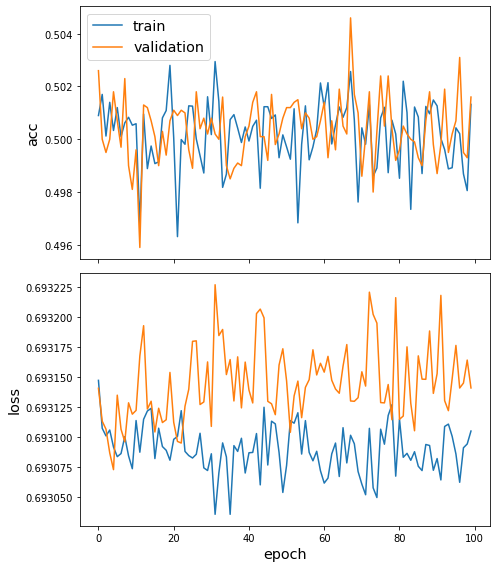

In [ ]:
sg.utils.plot_history(history)


Calculate the performance of the trained model on the test data.

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

10000/10000 [==============================] - 17s 2ms/step - loss: 0.6931 - acc: 0.4997

Test Set Metrics:
	loss: 0.6931
	acc: 0.4997


# Supervised graph classification with GCN

---




This notebook demonstrates how to train a graph classification model in a supervised setting using graph convolutional layers followed by a mean pooling layer as well as any number of fully connected layers.

The graph convolutional classification model architecture is based on the one proposed in [1] (see Figure 5 in [1]) using the graph convolutional layers from [2]. This demo differs from [1] in the dataset, MUTAG, used here; MUTAG is a collection of static graphs representing chemical compounds with each graph associated with a binary label. Furthermore, none of the graph convolutional layers in our model utilise an attention head as proposed in [1].

Evaluation data for graph kernel-based approaches shown in the very last cell in this notebook are taken from [3].

**References**

[1] Fake News Detection on Social Media using Geometric Deep Learning, F. Monti, F. Frasca, D. Eynard, D. Mannion, and M. M. Bronstein, ICLR 2019. ([link](https://arxiv.org/abs/1902.06673))

[2] Semi-supervised Classification with Graph Convolutional Networks, T. N. Kipf and M. Welling, ICLR 2017. ([link](https://arxiv.org/abs/1609.02907))

[3] An End-to-End Deep Learning Architecture for Graph Classification, M. Zhang, Z. Cui, M. Neumann, Y. Chen, AAAI-18. ([link](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146))

In [12]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 235kB 8.1MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 


In [13]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [14]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

### Prepare graph generator

To feed data to the `tf.Keras` model that we will create later, we need a data generator. For supervised graph classification, we create an instance of `StellarGraph`'s `PaddedGraphGenerator` class. Note that `graphs` is a list of `StellarGraph` graph objects.

In [15]:
generator = PaddedGraphGenerator(graphs=graphs)

### Create the Keras graph classification model

We are now ready to create a `tf.Keras` graph classification model using `StellarGraph`'s `GraphClassification` class together with standard `tf.Keras` layers, e.g., `Dense`. 

The input is the graph represented by its adjacency and node features matrices. The first two layers are Graph Convolutional as in [2] with each layer having 64 units and `relu` activations. The next layer is a mean pooling layer where the learned node representation are summarized to create a graph representation. The graph representation is input to two fully connected layers with 32 and 16 units respectively and `relu` activations. The last layer is the output layer with a single unit and `sigmoid` activation.

![](graph_classification_architecture.png)

In [16]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

    return model

### Train the model

We can now train the model using the model's `fit` method. First, we specify some important training parameters such as the number of training epochs, number of fold for cross validation and the number of time to repeat cross validation.

In [17]:
epochs = 33  # maximum number of training epochs
folds = 5  # the number of folds for k-fold cross validation
n_repeats = 3  # the number of repeats for repeated k-fold cross validation

In [18]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

The method `train_fold` is used to train a graph classification model for a single fold of the data.

In [19]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=2, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=2)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc

In [20]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

The code below puts all the above functionality together in a training loop for repeated k-fold cross-validation where the number of folds is 10, `folds=10`; that is we do 10-fold cross validation `n_repeats` times where `n_repeats=5`.

**Note**: The below code may take a long time to run depending on the value set for `n_repeats`. The larger the latter, the longer it takes since for each repeat we train and evaluate 10 graph classification models, one for each fold of the data. For progress updates, we recommend that you set `verbose=2` in the call to the `fit` method is cell 10, line 3.

In [ ]:
test_accs = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)

for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=30
    )

    model = create_graph_classification_model(generator)

    history, acc = train_fold(model, train_gen, test_gen, es, epochs)

    test_accs.append(acc)

Training and evaluating on fold 1 out of 15...
Epoch 1/33
2667/2667 - 20s - loss: 0.6971 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/33
2667/2667 - 17s - loss: 0.6933 - acc: 0.4998 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 3/33
2667/2667 - 17s - loss: 0.6933 - acc: 0.4973 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/33
2667/2667 - 17s - loss: 0.6933 - acc: 0.5009 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 5/33
2667/2667 - 17s - loss: 0.6937 - acc: 0.4992 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/33
2667/2667 - 17s - loss: 0.6933 - acc: 0.4996 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 7/33
2667/2667 - 17s - loss: 0.6933 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/33
2667/2667 - 17s - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 9/33
2667/2667 - 17s - loss: 0.6933 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 10/33
2667/2667 - 17s - loss: 0.6933 - acc: 0.4989 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 11/33
2667/2667 

In [ ]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 76.4% and std: 6.7%


Finally, we plot a histogram of the accuracy of all `n_repeats x folds` models trained (50 in total).

Text(0, 0.5, 'Count')

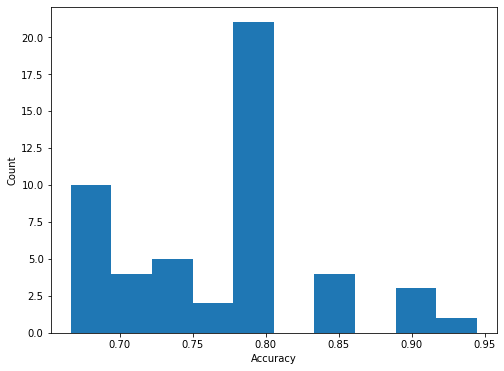

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")